# NLP: Analyzing Healthcare Reviews and Predicting Their Useful Vote

In [2]:
import os
import codecs
import json
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)

%matplotlib inline
import matplotlib.pyplot as plt

data_directory = os.path.join('/home/kist/yelp_13')
businesses_filepath = os.path.join(data_directory, 'business.json')
review_json_filepath = os.path.join(data_directory, 'review.json')
intermediate_directory = os.path.join(data_directory, 'intermediate')
review_txt_filepath = os.path.join(intermediate_directory, 'review_text_all.txt')


In [3]:
healthcare_ids = []

# open the businesses file
with codecs.open(businesses_filepath, encoding='utf_8') as f:
    # iterate through each line (json record) in the file
    for business_json in f:

        # convert the json record to a Python dict
        business = json.loads(business_json)

        # if this business has no categories or is not a target entity, skip to the next one
        if business[u'categories'] is None or u'Health & Medical' not in business[u'categories']:
            continue
        # Remove businesses in BW, Germany
        if u'BW' in business[u'state']:
            continue
        # Remove businesses that are restaurants, food and pets
        if u'Restaurants' in business[u'categories'] or u'Food' in business[u'categories'] or 'Pets' in business[
            u'categories']:
            continue

        # add the business id to our healthcare_ids set
        healthcare_ids.append(business[u'business_id'])

# Turn the list of ids into a set, which is faster for testing whether an element is in the set
healthcare_ids = set(healthcare_ids)

# print the number of unique ids in the dataset
print('{:,}'.format(len(healthcare_ids)), u'health & medical entities in the dataset.')

16,717 health & medical entities in the dataset.


In [4]:
# Create a new file that contains only the text from reviews about healthcare entities.
# One review per line in the this new file.

review_count = 0
useful = []

# create & open a new file in write mode
with codecs.open(review_txt_filepath, 'w', encoding='utf_8') as review_txt_file:
    # open the existing review json file
    with codecs.open(review_json_filepath, encoding='utf_8') as review_json_file:

        # loop through all reviews in the existing file and convert to dict
#         for review_json in review_json_file:
        loop_count = 0
        for review_json in review_json_file:

            review = json.loads(review_json)
            # if this review is not in the target set, skip to the next one
            if review[u'business_id'] not in healthcare_ids:
                continue

            # write each review as a line in the new file
            # escape newline characters in the original review text
            if review[u'text'] is None:
                print(review_count)

            review_txt_file.write(review[u'text'].replace('\n', '\\n').replace('\r', '') + '\n')
            review_count += 1
            useful.append(review[u'useful'])
            if loop_count > 1000:
                break
            loop_count += 1

print(u'Text from {:,} healthcare reviews written to the new txt file.'.format(review_count))

Text from 1,002 healthcare reviews written to the new txt file.


In [5]:
# Create a new file that contains only the text from reviews about healthcare entities.
# One review per line in the this new file.
    
review_count = 0
useful = []

# create & open a new file in write mode
with codecs.open(review_txt_filepath, 'w', encoding='utf_8') as review_txt_file:

    # open the existing review json file
    with codecs.open(review_json_filepath, encoding='utf_8') as review_json_file:

        # loop through all reviews in the existing file and convert to dict
        loop_count = 0

        for review_json in review_json_file:
            review = json.loads(review_json)

            # if this review is not in the target set, skip to the next one
            if review[u'business_id'] not in healthcare_ids:
                continue

            # write each review as a line in the new file
            # escape newline characters in the original review text
            if review[u'text'] is None:
                print(review_count)
            
            review_txt_file.write(review[u'text'].replace('\n', '\\n').replace('\r','') + '\n')
            review_count += 1
            useful.append(review[u'useful'])
            
            if loop_count > 1000:
                break
            loop_count += 1

print (u'Text from {:,} healthcare reviews written to the new txt file.'.format(review_count))

Text from 1,002 healthcare reviews written to the new txt file.


In [6]:
useful = np.array(useful)
luseful = np.log(useful+1)
df = pd.DataFrame(useful, columns=['useful'])
df.to_csv(os.path.join(intermediate_directory, 'useful.csv'))
# print(df)

22 22


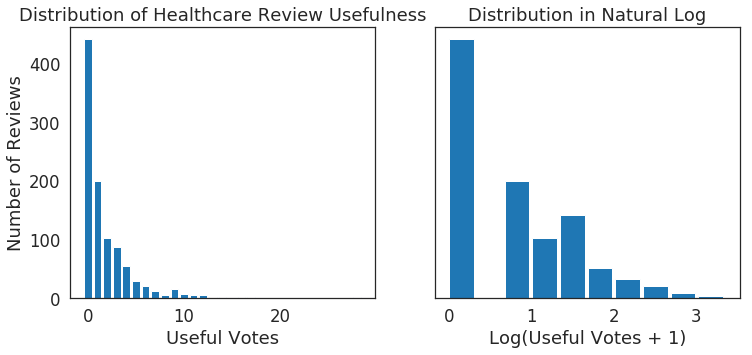

In [7]:
unique, counts = np.unique(useful, return_counts = True)
# print(unique)
# print(counts)
print(len(unique), len(counts))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches(12, 5)
ax1.bar(unique, counts)
ax1.set_title('Distribution of Healthcare Review Usefulness')
ax1.set_xlabel('Useful Votes')
ax1.set_ylabel('Number of Reviews')
ax2.set_title('Distribution in Natural Log')
ax2.hist(luseful, bins = 10, width = 0.3, align='mid')
ax2.set_xlabel('Log(Useful Votes + 1)')
f.savefig('useful_votes.png', dpi=100)
plt.show()

## Preprocessing the Text¶
I use spaCy to tokenize, lemmitize and remove stopwords from the text. Apply phrase modeling by looking for words that tend to appear one after another more frequently than by random chance.

In [8]:
import spacy
import pandas as pd
import itertools as it

# spacy.require_gpu()
nlp = spacy.load('en')

In [9]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence

unigram_sentences_filepath = os.path.join(intermediate_directory, 'unigram_sentences_all.txt')
bigram_model_filepath = os.path.join(intermediate_directory, 'bigram_model_all')
bigram_sentences_filepath = os.path.join(intermediate_directory, 'bigram_sentences_all.txt')
trigram_model_filepath = os.path.join(intermediate_directory, 'trigram_model_all')
trigram_sentences_filepath = os.path.join(intermediate_directory, 'trigram_sentences_all.txt')
trigram_reviews_filepath = os.path.join(intermediate_directory, 'trigram_transformed_reviews_all.txt')

In [10]:
def punct_space(token):
    """Eliminate tokens that are pure punctuation or white space"""
    
    return token.is_punct or token.is_space

def person(token):
    """Remove tokens that are PERSON entities"""
    
    return token.ent_type_ == 'PERSON'

def line_review(filename):
    """Generator function (iterator without storing all texts)
    to read in reviews from file and return the original line breaks"""
    
    with codecs.open(filename, encoding='utf_8') as f:
        for review in f:
            yield review.replace('\\n', '\n')

def lemmatized_sentence_corpus(filename):
    """Generator function to use spaCy to parse reviews, lemmatize the text and yield sentences"""
    
    for parsed_review in nlp.pipe(line_review(filename), batch_size=10000, n_threads=4):
        for sent in parsed_review.sents:
            yield u' '.join([token.lemma_ for token in sent 
                             if not (punct_space(token) or person(token))])

In [11]:

# Segment reviews into sentences and normalize the text
# Save the parsed sentences file on disk to avoid storing the entire corpus in RAM
with codecs.open(unigram_sentences_filepath, 'w', encoding='utf_8') as f:
    for sentence in lemmatized_sentence_corpus(review_txt_filepath):
        f.write(sentence + '\n')

In [16]:
# gensim's LineSentence class takes the format: one sentence = one line
# words are preprocessed and separated by whitespace.
unigram_sentences = LineSentence(unigram_sentences_filepath)
# print(unigram_sentences.limit)
for sentence in unigram_sentences:
    print(sentence)

None
['total', 'bill', 'for', 'this', 'horrible', 'service']
['over', '$', '8gs']
['these', 'crook', 'actually', 'have', 'the', 'nerve', 'to', 'charge', '-PRON-', '$', '69', 'for', '3', 'pill']
['-PRON-', 'check', 'online', 'the', 'pill', 'can', 'be', 'have', 'for', '19', 'cent', 'EACH']
['avoid', 'Hospital', 'ERs', 'at', 'all', 'cost']
['-PRON-', 'have', 'to', 'say', 'that', 'this', 'office', 'really', 'have', '-PRON-', 'together', '-PRON-', 'be', 'so', 'organized', 'and', 'friendly']
['Dr.', 'be', 'a', 'great', 'dentist', 'very', 'friendly', 'and', 'professional']
['the', 'dental', 'assistant', 'that', 'help', 'in', '-PRON-', 'procedure', 'be', 'amazing', 'and', 'help', '-PRON-', 'to', 'feel', 'comfortable']
['-PRON-', 'do', 'not', 'have', 'dental', 'insurance', 'but', '-PRON-', 'have', 'this', 'insurance', 'through', '-PRON-', 'office', '-PRON-', 'can', 'purchase', 'for', '$', '80', 'something', 'a', 'year', 'and', 'this', 'give', '-PRON-', '25', 'off', 'all', 'of', '-PRON-', 'denta

['some', 'of', 'the', 'care', 'giver', 'be', 'very', 'unprofessional', 'talk', 'to', 'resident', 'like', '-PRON-', 'little', 'child']
['also', 'the', 'staff', 'do', 'not', 'wear', 'name', 'tag', '-PRON-', 'should', 'communication', 'problem', 'between', 'family', 'and', 'staff', 'no', 'write', 'anything', 'down', 'create', 'alot', 'of', 'confusion']
['also', 'when', '-PRON-', 'first', 'arrive', 'the', 'entry', 'be', 'so', 'nice', 'and', 'so', 'be', 'the', 'sit', 'atrea', 'with', 'a', 'fireplace', 'but', 'where', 'the', 'resident', 'spend', '24', 'hour', 'a', 'day', 'lock', 'down', 'indoor', 'can', 'not', 'use', 'the', 'back', 'patio', '-PRON-', 'guess', '-PRON-', 'for', 'show']
['be', 'very', 'depressing', 'decor', 'and', 'color', 'and', 'the', 'place', 'smell', 'too']
['-PRON-', 'will', 'be', 'look', 'to', 'move', '-PRON-', 'family', 'member', 'out', 'of', 'there', 'if', 'thing', 'do', 'not', 'improve', 'soon']
['-PRON-', 'go', 'from', 'bad', 'to', 'bad']
['Do', 'not', 'rely', 'on', '

['-PRON-', 'have', 'basically', 'a', 'breakdown', 'over', 'too', 'much', 'pressure', 'when', '-PRON-', 'go', 'there', 'and', 'need', 'to', 'calm', 'down', '-PRON-', 'anxiety', 'with', 'a', 'reset', 'and', 'get', 'back', 'to', 'therapy']
['but', 'now', 'everything', 'be', 'screw', 'up']
['and', '-PRON-', 'be', 'contact', 'the', 'advocate', 'and', 'an', 'attorney', 'to', 'sue']
['-PRON-', 'be', 'sooooo', 'mad', 'at', 'what', 'be', 'do', 'and', 'the', 'Dr.', 'be', 'very', 'arrogant', 'not', 'even', 'take', '-PRON-', 'information', 'into', 'consideration']
['yes', '-PRON-', 'agree', '-PRON-', 'need', 'help']
['but', '-PRON-', 'only', 'focus', 'on', '1', 'thing', 'which', 'UMMMM', 'happen', 'to', 'be', 'a', 'specialization', 'of', 'patient', '-PRON-', 'deal', 'with', 'in', '-PRON-', 'private', 'practice']
['funny', 'huh']
['well', '-PRON-', 'need', 'to', 'go', 'get', '-PRON-', 'daughter', 'now', 'and', 'hopefully', 'get', 'require', 'paper', 'for', '-PRON-', 'to', 'see', '-PRON-', 'regular'

['both', 'Dr.', 'as', 'well', 'as', 'the', 'staff', 'at', 'the', 'front', 'desk', 'be', 'friendly', 'loving', 'kind', 'knowledgeable']
['-PRON-', 'make', '-PRON-', 'feel', 'value', 'and', 'care', 'for', 'and', 'put', '-PRON-', 'at', 'ease']
['every', 'single', 'one', 'of', '-PRON-', 'concern', 'be', 'address', 'and', 'completely', 'take', 'care', 'of']
['Dr.', 'know', 'what', 'each', 'thing', 'be', 'right', 'away', 'and', 'be', 'very', 'patient', 'with', '-PRON-', 'explain', 'what', 'be', 'go', 'on', 'with', 'each', 'condition', 'as', 'well', 'as', 'what', 'the', 'course', 'of', 'treatment', 'would', 'be', 'and', 'how', 'to', 'fix', '-PRON-']
['-PRON-', 'also', 'remove', 'a', 'skin', 'tag', 'for', '-PRON-', 'that', '-PRON-', 'want', 'go', 'in', 'just', 'a', 'few', 'second', 'with', 'absolutely', 'no', 'pain', 'during', 'or', 'after']
['-PRON-', 'be', 'completely', 'blow', 'away', 'and', 'can', 'not', 'say', 'enough', 'good', 'thing', 'about', 'Spectrum', 'Dermatology']
['when', '-PRON-

In [18]:

# Run a phrase model to link two-words phrases together
bigram_model = Phrases(unigram_sentences)
bigram_model.save(bigram_model_filepath)
bigram_model = Phrases.load(bigram_model_filepath)


In [19]:
# Apply the bigram model to unigram sentences and create a text with bigram sentences
with codecs.open(bigram_sentences_filepath, 'w', encoding='utf-8') as f:
    for unigram_sentence in unigram_sentences:
        bigram_sentence = u' '.join(bigram_model[unigram_sentence])
        f.write(bigram_sentence + '\n')

total bill for this horrible service
over $ 8gs
these crook actually have the nerve to charge -PRON- $ 69 for 3 pill
-PRON- check online the pill can be have for 19 cent EACH
avoid Hospital ERs at all cost
-PRON- have to say that this office really have -PRON- together -PRON- be so organized and friendly
Dr. be a great dentist very_friendly and professional
the dental assistant that help in -PRON- procedure be amazing and help -PRON- to feel_comfortable
-PRON- do_not have dental insurance but -PRON- have this insurance through -PRON- office -PRON- can purchase for $ 80 something a year and this give -PRON- 25 off all of -PRON- dental_work plus -PRON- help -PRON- get sign_up for care credit which -PRON- know nothing about before this visit
-PRON- highly_recommend this office for the nice synergy the whole office have
-PRON- be year out from surgery with sacs and -PRON- wish -PRON- could turn back time
-PRON- promise great thing -PRON- butcher -PRON- body
-PRON- should have leave -PRON- 

-PRON- also have chiropractic and acupunture service as_well
-PRON- would_highly recommend_this place if -PRON- be look for compassionate comprehensive and affordable healing therapy
-PRON- feel_comfortable and relaxed every_time -PRON- walk_in for -PRON- appointment
-PRON- have so_much advice and be knowledgeable about so many thing
-PRON- look_forward to all monthly appointment
-PRON- love Doctor but hate the wait time
-PRON- be on time but still wait 45 to an_hour to be see
that be disrespectful
be amazing
-PRON- have really help -PRON- son so_much after -PRON- motorcycle accident
-PRON- s have so_much less pain and stiffness without_any drug
thank -PRON- and Athletes for Life
what a blessing -PRON- be
-PRON- 19-year old daughter have be see Dr. for a_few month for -PRON- acne
the treatment_plan -PRON- have -PRON- on be work
-PRON- really like -PRON- a_lot and say the office staff be friendly
this belate thank -PRON- be inspire by an recent unpleasant visit with -PRON- young daughte

-PRON- be guess the review from be fabricate by a family friend of the staff
Everyone -PRON- talk to here have nothing nice to say about this_place
also thing tend to come up miss here
from food that only the staff have access to along_with a sweatshirt take out of -PRON- room
thing here seem to grow leg
-PRON- love New Image
-PRON- Husband and -PRON- both go there
-PRON- get -PRON- visible tattoo remove just in time before -PRON- start -PRON- new job
-PRON- be completely go
-PRON- get las hair_removal facial exc
when u look good u feel good
Dr. be amazing
-PRON- be really friendly and make -PRON- feel so comfortable
be the BEST
-PRON- smile alone be so warm
-PRON- pay very close attention to detail and give u the good advise for ur skin
love -PRON- at Shadow Mountain Massage Envy
Great Massage Therapists and front_desk people
-PRON- only get -PRON- massage here
dr have the personality of a turnip and have the bad bedside_manner -PRON- have ever see
a typical appointment with -PRON- go

please take a patient allergy seriously when the CLEARLY spell THEM out for you
medshape be a misleading name as -PRON- would lead client to believe that -PRON- have some medical experience
-PRON- push a weight_loss powder on -PRON- that contain an allergen that send -PRON- to the ER with a severe allergic reaction require hospitalization
no -PRON- do_not look closely at the ingredient because -PRON- be a medical facility which -PRON- assume after pay -PRON- a significant amount of money would never give -PRON- something -PRON- be allergic to
not only should -PRON- pay for -PRON- hospital stay but at the very least should refund the money -PRON- pay -PRON- for nothing
oh and have -PRON- ever hear of HIPPA
seriously call another patient phone number because -PRON- do_not believe -PRON- be not the same patient because -PRON- name and DOB be so similar
absolutely unbelievable incompetence
do_not let -PRON- give zero star more important that other be make aware
-PRON- be see here today by 

-PRON- ridicule people and have a really bad attitude
the guy think -PRON- be a know -PRON- all about the pain level
-PRON- be in which -PRON- have no clue about
and if -PRON- be not for -PRON- be adamant about how bad -PRON- ear be hurt -PRON- would not have get the help -PRON- need
this be not a reflection of the staff -PRON- be courteous but -PRON- be UNDERSTAFFED
just walk_out after wait two hour for a chest x_ray
unfortunately -PRON- be the only diagnostic test -PRON- can_not make an_appointment for
after a night of liquid libation -PRON- wake_up feel not so hot and even bad as the day progress
-PRON- research the miracle hangover cure business online
after see one business that post video of an IV go in -PRON- decide against -PRON-
after about an_hour -PRON- be desperate and do_not want to feel terrible all day -PRON- have -PRON- husband call Reset IV
-PRON- husband explain -PRON- fear of needle and ask to send the good person for the job
boy do -PRON- ever
be FANTASTIC
-PRON- as

have to call in a RX refill be quite the fiasco since -PRON- have to leave -PRON- the pharmacy 's phone and location evidently -PRON- can_not or will not look -PRON- up on Google if the wrong be accidentally give -PRON- bday what medication -PRON- need the dosage amount etc
do_not -PRON- have record of that
the answer be yes but -PRON- can_not be bother to look -PRON- up
-PRON- be a_bit difficult to get in touch with
-PRON- also charge md price when -PRON- be just a nurse practitioner
this_place recently open and be absolutely amazing
-PRON- boyfriend and -PRON- book a one hour foot_massage for $ 25 each
not expect much -PRON- very quite surprised when -PRON- be ask to remove jewelry not on -PRON- foot and jacket
-PRON- foot in a bucket of warm water -PRON- lie down on the comfortable massage bed and so -PRON- begin
not with the foot but with a face and scalp massage go to the neck and shoulder the arm and hand and then after the leg to the foot which receive much attention
then -PRON-

-PRON- say that -PRON- do_not have blood testing or any_other type_of testing -PRON- need
an Urgent Care that give no care
Do not go
-PRON- will take -PRON- urgent_care co -pay in -PRON- situation $ 150 for nothing
-PRON- tell -PRON- to go to the hospital
so -PRON- ask for the $ 150 back so that -PRON- could go somewhere that COULD help -PRON- refuse and then say -PRON- be talk to -PRON-
WTF
how be talk to -PRON- go to help -PRON- medical problem
the place be dirty
blood on the floor in the waiting_room right next to couch
staff be very unprofessional except for one lady and -PRON- sit around and discuss -PRON- personal life the entire time
-PRON- office staff even have bad appearance
-PRON- look like 80 of -PRON- roll out of bed and come in
the doctor give a prescription for an over the counter medication without even figure out what -PRON- problem be what a crock
do_not waste -PRON- time here
-PRON- do_not help
this_place be clean and organized
the employee smile and be pleasant
-PRO

In [20]:
bigram_sentences = LineSentence(bigram_sentences_filepath)
count = 0
for sentence in bigram_sentences:
    count += 1
    print(sentence)
    if count > 10:
        break

['total', 'bill', 'for', 'this', 'horrible', 'service']
['over', '$', '8gs']
['these', 'crook', 'actually', 'have', 'the', 'nerve', 'to', 'charge', '-PRON-', '$', '69', 'for', '3', 'pill']
['-PRON-', 'check', 'online', 'the', 'pill', 'can', 'be', 'have', 'for', '19', 'cent', 'EACH']
['avoid', 'Hospital', 'ERs', 'at', 'all', 'cost']
['-PRON-', 'have', 'to', 'say', 'that', 'this', 'office', 'really', 'have', '-PRON-', 'together', '-PRON-', 'be', 'so', 'organized', 'and', 'friendly']
['Dr.', 'be', 'a', 'great', 'dentist', 'very_friendly', 'and', 'professional']
['the', 'dental', 'assistant', 'that', 'help', 'in', '-PRON-', 'procedure', 'be', 'amazing', 'and', 'help', '-PRON-', 'to', 'feel_comfortable']
['-PRON-', 'do_not', 'have', 'dental', 'insurance', 'but', '-PRON-', 'have', 'this', 'insurance', 'through', '-PRON-', 'office', '-PRON-', 'can', 'purchase', 'for', '$', '80', 'something', 'a', 'year', 'and', 'this', 'give', '-PRON-', '25', 'off', 'all', 'of', '-PRON-', 'dental_work', 'plus

['appointment', 'be', 'flexible', 'and', 'price', 'be', 'competetive']
['this', 'be', 'a', 'no', 'pressure', 'place-', 'unlike', 'other', 'place']
['-PRON-', 'can', 'buy', '-PRON-', 'frame', 'contact']
['there']
['or', '-PRON-', 'will', 'give', '-PRON-', '-PRON-', 'prescription', 'and', '-PRON-', 'can', 'go', 'elsewhere']
['-PRON-', 'be', 'not', 'familiar', 'with', 'any', 'of', 'the', 'other', 'doctor', 'that', 'be', 'there']
['but', 'if', '-PRON-', 'need', 'a', 'great', 'eye', 'doctor-', 'try', 'Dr.']
['Dr.', 'help', 'lessen', '-PRON-', 'dry', 'eye', 'and', 'give', '-PRON-', 'back', 'tear', 'when', '-PRON-', 'formerly', 'have', 'none']
['-PRON-', 'also', 'improve', '-PRON-', 'vision', 'from', '20/600', 'to', '20/350', 'in', 'one', 'eye']
['the', 'ophthalmologist', 'say', '-PRON-', 'be', 'like', '-PRON-', 'be', 'look', 'at', 'the', 'vision', 'of', 'a', 'different', 'person']
['Dr.', 'be', 'also', 'treat', '-PRON-', 'for', 'neuropathy', 'and', '-PRON-', 'have', 'indication', 'that', '-P

['this', 'be', 'a', 'great', 'place', 'to', 'go', 'sit', 'if', '-PRON-', 'do_not', 'have', 'anywhere_else', 'to', 'go']
['but', 'i', 'suggest', '-PRON-', 'take', 'food', 'water', 'lol', 'cause', '-PRON-', 'be', 'go', 'to', 'need', '-PRON-']
['and', '-PRON-', 'could', 'not', 'numb', '-PRON-', 'mouth', 'enough', 'where', '-PRON-', 'do_not', 'feel', 'the', 'pain']
['see', 'that', 'be', 'the', 'reason', 'most', 'people', 'be', 'scared', 'of', 'the', 'dentist', '-PRON-', 'never', 'have', 'to', 'have', 'a', 'tooth_pull', 'before']
['so', 'this', 'be', 'an', 'awful', 'experience', 'for', 'her!!only', 'reason', 'i', 'give', '2', 'star']
['be', 'because', 'the', 'people', 'work', 'there', 'be', 'nice', 'and', 'the', 'place', 'be', 'clean']
['but', 'service', 'be', 'soooooo', 'slow']
['-PRON-', 'will', 'never', 'come_back', 'here', 'again', 'for', 'any', 'dental_work']
['and', '-PRON-', "wasen't", 'like', '-PRON-', 'be', 'pack', 'or', 'anything']
['when', '-PRON-', 'arrive', '-PRON-', 'be', '2',

['the', 'list', 'go', 'on']
['-PRON-', 'can', 'absolutely', 'say', 'that', '-PRON-', 'will', 'never', 'again', 'be', 'use', 'the', 'Dignity', 'Health', 'network', 'as', 'the', 'charge', 'impose', 'be', 'absolutely', 'ridiculous', 'for', 'a', 'responsible', 'consumer', 'who', 'be', 'in', 'need', 'of', 'healthcare']
['True', 'Dentistry', 'be', 'great']
['the', 'office', 'be', 'very_nice', 'and', 'clean']
['Dr.', 'do', 'the', 'good', 'filling', '-PRON-', 'have', 'ever', 'have']
['and', '-PRON-', 'do_not', 'even', 'feel', 'the', 'shot']
['honestly', 'i', 'do_not', 'know_what', 'to', 'expect', 'when', '-PRON-', 'son', 'and', 'i', 'show_up', 'for', '-PRON-', 'first', 'appointment', 'at', 'this', 'office']
['i', 'have', 'have', 'both', 'good', 'and', 'bad_experience', 'in', 'the', 'past', 'in', 'all', 'medical', 'type', 'environment', 'as', '-PRON-', 'son', 'be', 'autistic', 'and', 'i', 'never', 'know', 'just', 'how', 'far', 'i', 'can', 'push', '-PRON-', 'on', 'a', 'daily', 'basis']
['the', '

In [22]:
trigram_model = Phrases(bigram_sentences)
trigram_model.save(trigram_model_filepath)
trigram_model = Phrases.load(trigram_model_filepath)

In [23]:
with codecs.open(trigram_sentences_filepath, 'w', encoding='utf_8') as f:
    for bigram_sentence in bigram_sentences:
        trigram_sentence = u' '.join(trigram_model[bigram_sentence])
        f.write(trigram_sentence + '\n')

In [25]:
trigram_sentences = LineSentence(trigram_sentences_filepath)

count = 0
for sentence in bigram_sentences:
    count += 1
    print(sentence)
    if count > 5:
        break

        
count = 0 
for sentence in unigram_sentences:
    count += 1
    print(sentence)
    if count > 5:
        break

count = 0
for sentence in trigram_sentences:
    count += 1
    print(sentence)
    if count > 5:
        break

['total', 'bill', 'for', 'this', 'horrible', 'service']
['over', '$', '8gs']
['these', 'crook', 'actually', 'have', 'the', 'nerve', 'to', 'charge', '-PRON-', '$', '69', 'for', '3', 'pill']
['-PRON-', 'check', 'online', 'the', 'pill', 'can', 'be', 'have', 'for', '19', 'cent', 'EACH']
['avoid', 'Hospital', 'ERs', 'at', 'all', 'cost']
['-PRON-', 'have', 'to', 'say', 'that', 'this', 'office', 'really', 'have', '-PRON-', 'together', '-PRON-', 'be', 'so', 'organized', 'and', 'friendly']
['total', 'bill', 'for', 'this', 'horrible', 'service']
['over', '$', '8gs']
['these', 'crook', 'actually', 'have', 'the', 'nerve', 'to', 'charge', '-PRON-', '$', '69', 'for', '3', 'pill']
['-PRON-', 'check', 'online', 'the', 'pill', 'can', 'be', 'have', 'for', '19', 'cent', 'EACH']
['avoid', 'Hospital', 'ERs', 'at', 'all', 'cost']
['-PRON-', 'have', 'to', 'say', 'that', 'this', 'office', 'really', 'have', '-PRON-', 'together', '-PRON-', 'be', 'so', 'organized', 'and', 'friendly']
['total', 'bill', 'for', 'th

In [28]:
# Write a transformed text into a new file, with one review per line
roop_count = 0

from pprintpp import pprint

with codecs.open(trigram_reviews_filepath, 'w', encoding='utf-8') as f:
    for parsed_review in nlp.pipe(line_review(review_txt_filepath), batch_size=10000, n_threads=4):

        # Lemmatize the text, removing punctuation and whitespace
        unigram_review = [token.lemma_ for token in parsed_review 
                          if not (punct_space(token) or person(token))]

        # Apply the first-order and second-order phrase models
        bigram_review = bigram_model[unigram_review]
        trigram_review = trigram_model[bigram_review]

#         print(trigram_review[:50])
        # Remove any remaining stopwords
#         trigram_review = [term for term in trigram_review if term not in spacy.en.language_data.STOP_WORDS]
#         trigram_review = [term for term in trigram_review if term not in spacy.en.word_sets.stop_words]
        trigram_review = [term for term in trigram_review if term not in nlp.Defaults.stop_words]
        roop_count += 1
#         print("roop {}".format(roop_count))
#         if roop_count < 10:
#             pprint("review : {}".format(trigram_review))

        # Write the transformed review as a new line
        trigram_review = u' '.join(trigram_review)
        f.write(trigram_review + '\n')
        
print("=== Preprocessing finishied ===")

count = 0
for review in unigram_review:
    count += 1
    print(review)
    if count > 5:
        break
        

print("======")

count = 0
for review in bigram_review:
    count += 1
    print(review)
    if count > 5:
        break

print("======")
        
count = 0
for review in trigram_review:
    count += 1
    print(review)
    if count > 5:
        break

=== Preprocessing finishied ===
-PRON-
boyfriend
and
-PRON-
have
be
-PRON-
boyfriend
and
-PRON-
have
be
-
P
R
O
N
-


## Train a Word2Vec Model


In [47]:
from gensim.models import Word2Vec
word2vec_filepath = os.path.join(intermediate_directory, 'word2vec_model_all')

In [53]:
for trigram_sentence in trigram_sentences:
    print(trigram_sentence)

# print(trigram_sentences.sentences)

['total', 'bill', 'for', 'this', 'horrible', 'service']
['over', '$', '8gs']
['these', 'crook', 'actually', 'have', 'the', 'nerve', 'to', 'charge', '-PRON-', '$', '69', 'for', '3', 'pill']
['-PRON-', 'check', 'online', 'the', 'pill', 'can', 'be', 'have', 'for', '19', 'cent', 'EACH']
['avoid', 'Hospital', 'ERs', 'at', 'all', 'cost']
['-PRON-', 'have', 'to', 'say', 'that', 'this', 'office', 'really', 'have', '-PRON-', 'together', '-PRON-', 'be', 'so', 'organized', 'and', 'friendly']
['Dr.', 'be', 'a', 'great', 'dentist', 'very_friendly', 'and', 'professional']
['the', 'dental', 'assistant', 'that', 'help', 'in', '-PRON-', 'procedure', 'be', 'amazing', 'and', 'help', '-PRON-', 'to', 'feel_comfortable']
['-PRON-', 'do_not', 'have', 'dental', 'insurance', 'but', '-PRON-', 'have', 'this', 'insurance', 'through', '-PRON-', 'office', '-PRON-', 'can', 'purchase', 'for', '$', '80', 'something', 'a', 'year', 'and', 'this', 'give', '-PRON-', '25', 'off', 'all', 'of', '-PRON-', 'dental_work', 'plus

['-PRON-', 'be', 'visit', 'from', 'Boston', 'and', 'have', 'travel', 'to', 'a', 'bunch', 'of', 'ymca', 'but', 'this', 'be', 'by_far', 'the', 'most', 'impressive', 'facility']
['-PRON-', 'have', 'a', 'woman', "'s", 'only', 'fitness', 'center', 'in', 'the', 'woman', "'s", 'locker_room', 'for', "'s", 'sake']
['the', 'machine', 'in', 'there', 'have', 'see', 'well', 'day', 'but', 'the', 'gym', 'on', 'the', 'third', 'floor', 'be', 'top_notch']
['-PRON-', 'have', 'a', 'piano']
['the', 'staff', 'be', 'friendly', 'and', 'everyone', 'seem', 'to', 'be', 'smile']
['-PRON-', 'be', 'only', 'not', 'give', 'the', 'facility', '5_star', 'because', '-PRON-', 'visitor', 'policy', 'be', '3x', 'per', 'month', 'which', 'be', 'very', 'limit', 'for', '-PRON-', 'as', 'a', 'member', 'of', 'another', 'YMCA', 'and', 'as', 'someone_who', 'travel', 'for', 'work']
['-PRON-', 'membership', 'due', 'be', 'base', 'on', 'household', 'income', 'which', 'be', 'an', 'interesting', 'model', 'that', 'clearly', 'allow', '-PRON-

['Dr.', 'take', 'the', 'time', 'to', 'answer_all', '-PRON-', 'question', 'and', 'be', 'great', 'to', 'talk', 'to']
['Miley', 'be', 'awesome']
['-PRON-', 'shape', '-PRON-', 'nail', 'perfectly', 'exactly', 'how', '-PRON-', 'want', 'm']
['-PRON-', 'have', 'come', 'a_few', 'time', 'now', 'and', '-PRON-', 'acrylic', 'with', 'gel', 'polish', 'last', '3', 'full', 'week', 'without', 'a', 'chip', 'or', 'scratch']
['the', 'salon', '-PRON-', 'be', 'decorate', 'nicely', 'very', 'modern', 'and', 'clean']
['-PRON-', 'always', 'offer', 'something', 'to', 'drink', 'which', 'be', 'a', 'very_nice', 'touch']
['overall', 'great_experience', 'every_time']
['the', 'service', 'provide', 'at', 'be', 'excellent']
['Dr.', 'be', 'a', 'wonderful', 'doctor']
['the', 'staff', 'be', 'very_friendly', 'and', 'approachable']
['-PRON-', 'make_sure', '-PRON-', 'be', 'not', 'wait', 'long', 'and', '-PRON-', 'need', 'be', 'address']
['-PRON-', 'have', 'a', 'great', 'selection', 'of', 'eye', 'glass', 'and', 'sun', 'glass', '

['the', 'place', 'have', 'a', 'nice', 'aromatic', 'scent', 'go', 'on', 'and', 'the', 'music', 'be', 'pretty', 'relaxing', 'although', '-PRON-', 'could', 'have', 'do', 'without', 'the', 'instrumental', 'version', 'of']
['-PRON-', 'heart', 'Will', 'go', 'on', 'and', '-PRON-', 'masseuse', 'hum', 'along', 'to', '-PRON-']
['-PRON-', 'guy', 'be', 'very_nice', 'and', 'do', 'an', 'alright', 'job']
['-PRON-', 'go', 'a_bit', 'light', 'on', '-PRON-', 'so', '-PRON-', 'be', 'not', 'as', 'deep', 'of', 'a', 'foot_massage', 'as', '-PRON-', 'would', 'have', 'like']
['-PRON-', 'be', 'pretty', 'relaxed', 'though', 'and', 'that', 'be', 'what', '-PRON-', 'need']
['-PRON-', 'boyfriend', 'say', '-PRON-', 'enjoy', '-PRON-', 'but', 'what', '-PRON-', 'do_not', 'like', 'be', 'that', '-PRON-', 'therapist', 'be', 'sit', 'right', 'next', 'to', '-PRON-', 'and', 'keep', 'burping']
['gross']
['-PRON-', 'boyfriend', "'s", 'therapist', 'do_not', 'speak', 'English', 'at', 'all']
['usually', 'that', 'be', 'not', 'really',

# Train a word2vec model: 100-dimensional word vectors

In [54]:
word2vec = Word2Vec(size=100, window=5, min_count=50, sg=0, workers=4)
word2vec.build_vocab(trigram_sentences) 
word2vec.train(trigram_sentences, total_examples=word2vec.corpus_count, epochs=10)
word2vec.save(word2vec_filepath)

word2vec = Word2Vec.load(word2vec_filepath)

In [55]:
print(u'{:,} terms in the word2vec vocabulary.'.format(len(word2vec.wv.vocab)))


248 terms in the word2vec vocabulary.


In [56]:
# build a list of terms, index, and term counts from the word2vec model
ordered_vocab = [(term, vocab.index, vocab.count) for term, vocab in word2vec.wv.vocab.items()]
ordered_vocab = sorted(ordered_vocab, key=lambda ordered_vocab:ordered_vocab[2], reverse=True)
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

In [57]:
# Creat a dictionary mapping each word to a 100-dimensional vector
word_vectors = dict(list(zip(word2vec.wv.index2word, word2vec.wv.syn0)))

/home/kist/pex_ws/src/text_based_pr/venv2/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [58]:
word2vec.most_similar(positive=['dentist'], topn=5)


/home/kist/pex_ws/src/text_based_pr/venv2/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('doctor', 0.9932866096496582),
 ('place', 0.9871119260787964),
 ('price', 0.9823453426361084),
 ('as_well', 0.9802402257919312),
 ('location', 0.9800056219100952)]

In [59]:
word2vec.most_similar(positive=['dentist', 'baby'], negative=['tooth'],topn=5)


/home/kist/pex_ws/src/text_based_pr/venv2/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


KeyError: "word 'baby' not in vocabulary"

## Training a Doc2Vec Model¶

In [24]:
# Gensim's Doc2Vec class creates vector representations for entire documents
# The input object is an iterator of LineSentence objects
# The default dm=1 refers to the distributed memory algorithm
# The algorithm runs through sentences twice: (1) build the vocab, 
# (2) learn a vector representation for each word and for each label (sentence)
# Better results can be achieved by iterating over the data several times

from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
doc2vec_filepath = os.path.join(intermediate_directory, 'doc2vec_model')

In [25]:
X = []
with codecs.open(trigram_reviews_filepath, encoding='utf-8') as f:
    for review in f:
        X.append(review)

labels = ['Review_' + str(x) for x in range(len(X))]

In [27]:
print(labels[:100])

['Review_0', 'Review_1', 'Review_2', 'Review_3', 'Review_4', 'Review_5', 'Review_6', 'Review_7', 'Review_8', 'Review_9', 'Review_10', 'Review_11', 'Review_12', 'Review_13', 'Review_14', 'Review_15', 'Review_16', 'Review_17', 'Review_18', 'Review_19', 'Review_20', 'Review_21', 'Review_22', 'Review_23', 'Review_24', 'Review_25', 'Review_26', 'Review_27', 'Review_28', 'Review_29', 'Review_30', 'Review_31', 'Review_32', 'Review_33', 'Review_34', 'Review_35', 'Review_36', 'Review_37', 'Review_38', 'Review_39', 'Review_40', 'Review_41', 'Review_42', 'Review_43', 'Review_44', 'Review_45', 'Review_46', 'Review_47', 'Review_48', 'Review_49', 'Review_50', 'Review_51', 'Review_52', 'Review_53', 'Review_54', 'Review_55', 'Review_56', 'Review_57', 'Review_58', 'Review_59', 'Review_60', 'Review_61', 'Review_62', 'Review_63', 'Review_64', 'Review_65', 'Review_66', 'Review_67', 'Review_68', 'Review_69', 'Review_70', 'Review_71', 'Review_72', 'Review_73', 'Review_74', 'Review_75', 'Review_76', 'Review_

In [30]:
class DocIterator():
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield LabeledSentence(words=doc.split(), tags=[self.labels_list[idx]])

In [31]:
labeled_reviews = DocIterator(X, labels)


In [35]:
print(labeled_reviews.labels_list)

['Review_0', 'Review_1', 'Review_2', 'Review_3', 'Review_4', 'Review_5', 'Review_6', 'Review_7', 'Review_8', 'Review_9', 'Review_10', 'Review_11', 'Review_12', 'Review_13', 'Review_14', 'Review_15', 'Review_16', 'Review_17', 'Review_18', 'Review_19', 'Review_20', 'Review_21', 'Review_22', 'Review_23', 'Review_24', 'Review_25', 'Review_26', 'Review_27', 'Review_28', 'Review_29', 'Review_30', 'Review_31', 'Review_32', 'Review_33', 'Review_34', 'Review_35', 'Review_36', 'Review_37', 'Review_38', 'Review_39', 'Review_40', 'Review_41', 'Review_42', 'Review_43', 'Review_44', 'Review_45', 'Review_46', 'Review_47', 'Review_48', 'Review_49', 'Review_50', 'Review_51', 'Review_52', 'Review_53', 'Review_54', 'Review_55', 'Review_56', 'Review_57', 'Review_58', 'Review_59', 'Review_60', 'Review_61', 'Review_62', 'Review_63', 'Review_64', 'Review_65', 'Review_66', 'Review_67', 'Review_68', 'Review_69', 'Review_70', 'Review_71', 'Review_72', 'Review_73', 'Review_74', 'Review_75', 'Review_76', 'Review_

In [60]:
# To produce better results, iterate over the data 10 times
# and control the learning rate for each iteration
doc2vec = Doc2Vec(size=100, window=5, min_count=50, workers=4, iter=10)
doc2vec.build_vocab(labeled_reviews)

doc2vec.train(labeled_reviews, total_examples=doc2vec.corpus_count, epochs=10)

doc2vec.save(doc2vec_filepath)
doc2vec.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
doc2vec = Doc2Vec.load(doc2vec_filepath)

/home/kist/pex_ws/src/text_based_pr/venv2/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  import sys


In [61]:
doc2vec.most_similar(positive=["pediatrician"], topn=5)


/home/kist/pex_ws/src/text_based_pr/venv2/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


KeyError: "word 'pediatrician' not in vocabulary"

In [62]:
doc2vec.most_similar(positive=['pediatrician','tooth'], negative=['baby'], topn=5)


/home/kist/pex_ws/src/text_based_pr/venv2/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


KeyError: "word 'pediatrician' not in vocabulary"

In [29]:
doc2vec.docvecs.most_similar('Review_10', topn=5)


NameError: name 'doc2vec' is not defined